# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
from scipy import signal
import math
import time as toc
import import_ipynb
import os


try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from SpatialTemporal_Correlation_and_Convolution import STcorrelate
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from SpatialTemporal_Correlation_and_Convolution import STconvolve
from Spike_Generation import NL
from StimulusnResponse import SSG
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\MB_FB_model')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\MB_FB_model')
%matplotlib inline

importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb


In [2]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

In [3]:
def FB_FF_1l_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = min(max(sigma_dict.values())*3, int(stimulus.shape[1]/2/dx))
    xx = np.arange(-klen,klen+dx,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
#     plt.plot(KC)
#     plt.plot(KH)
#     plt.plot(KB)
#     plt.plot(KC-KH)
    
    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak1 = np.zeros(np.shape(stimulus)[0])
    rpeak2 = np.zeros(np.shape(stimulus)[0])
    rinvertpeak2 = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry2z = np.convolve(yts[i-1,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dyj =(-para_dict['alpha']*yts[i-1,:]+para_dict['k']*(rs-para_dict['phi']*zts[i-1,:]))*dt
        dzj =(-para_dict['beta']*zts[i-1,:]+para_dict['g']*ry2z)*dt
                
        yts[i,:] = (yts[i-1,:]+dyj)*loc_dict['C']
        zts[i,:] = (zts[i-1,:]+dzj)*loc_dict['H']
        ry2w = np.convolve(yts[i-1,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dwj =(-para_dict['gramma']*wts[i-2,:]+para_dict['p']*((1-para_dict['psy'])*ry2w-para_dict['psy']*zts[i-1,:]))*dt

        wts[i-1,:] = (wts[i-2,:]+dwj)
        maxpos1 = np.argmax(yts[i,:])
        rpeak1[i]= maxpos1*dx
        maxpos2 = np.argmax(wts[i-1,:])
        rpeak2[i-1]= maxpos2*dx
        maxipos2 = np.argmin(wts[i-1,:])
        rinvertpeak2[i-1]= maxipos2*dx
    
    ry2w = np.convolve(yts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    dwj =(-para_dict['gramma']*wts[i-1,:]+para_dict['p']*((1-para_dict['psy'])*ry2w-para_dict['psy']*zts[i,:]))*dt
    wts[i,:] = (wts[i-1,:]+dwj)
    maxpos2 = np.argmax(wts[i,:])
    rpeak2[i]= maxpos2*dx
    maxipos2 = np.argmin(wts[i,:])
    rinvertpeak2[i]= maxipos2*dx
    return wts, zts, yts, rpeak1, rpeak2, rinvertpeak2

In [4]:
def Ay(para_dict, sigma_dict, x, n = 1000):
    alpha = para_dict['alpha']
    beta = para_dict['beta']
    k = para_dict['k']
    phi = para_dict['phi']
    g = para_dict['g']
    sigma_h = sigma_dict['H']
    sigma_c = sigma_dict['C']
    ans =  0
    for i in range(n+1):
        ans += k/alpha/np.sqrt(np.pi)*(-k*g/alpha/beta)**i/np.sqrt(sigma_c**2+i*sigma_h**2)*np.exp(-x**2/(sigma_c**2+i*sigma_h**2))
    return ans

# Setting parameters

## CKC's parameters

In [5]:
filename = 'CKC STkernels-good parameters'

NGD_sigma_dict = dict()
NGD_sigma_dict['H'] = 1
NGD_sigma_dict['C'] = NGD_sigma_dict['H']*0.1 # RF size of cone cell
dx = NGD_sigma_dict['H']/40.

dt=0.01  #large dt will cause  overflow
nstep = int(1.6/dt)
NGD_sigma_dict['tau_y'] = 0.02
#Width setting
xlen = 50*NGD_sigma_dict['H'] #spatial extend of simulation
# Dynamical_range = 6*NGD_sigma_dict['H']/dx #188-16 pixels
# hw = 3*Dynamical_range*dx/22 #half bar width  #8 pixels

NGD_para_dict = {}
NGD_para_dict['alpha'] = 14.
NGD_para_dict['beta'] = 4.2
NGD_para_dict['k'] = 20. #not important if there is no adaption
NGD_para_dict['phi'] = 1.
NGD_para_dict['g'] = 26. #but k*g are important


FBFF_sigma_dict = NGD_sigma_dict.copy()
FBFF_para_dict = NGD_para_dict.copy()
FBFF_para_dict['gramma'] = 21.
FBFF_para_dict['p'] = 100. # not important if there is no adaption
FBFF_para_dict['psy'] = 0.04

FBFF_sigma_dict['B'] = FBFF_sigma_dict['H']*0.3

# para_dict['g']*para_dict['k']*para_dict['phi']/para_dict['alpha']/para_dict['beta']

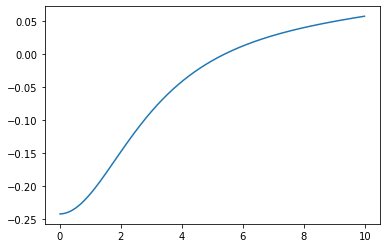

In [6]:
alpha = FBFF_para_dict['alpha']
beta = FBFF_para_dict['beta']
gamma = FBFF_para_dict['gramma']
k = FBFF_para_dict['k']
g = FBFF_para_dict['g']
p = FBFF_para_dict['p']
psy = FBFF_para_dict['psy']
dOmega = 0.01
omega = np.arange(dOmega,10,dOmega)
H = k*p*((omega*1j+beta)*(1-psy)-psy*g)/(omega*1j+gamma)/((omega*1j+alpha)*(omega*1j+beta)+k*g)
G = np.abs(H)
Phi = np.angle(H)
delta = -np.append(np.diff(Phi),0)/dOmega
    
plt.plot(omega[:-1], delta[:-1])

# TK

In [7]:
TDelta_input = np.zeros([int(2/dt), int(xlen/dx)+1])
TDelta_input[0,:] = 2
TDelta_output_w, zts, TDelta_output_y, _, _, _ = FB_FF_1l_1D(TDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)
# Delta_output =Delta_output_w

Text(0.5, 1.0, 'temporal filter')

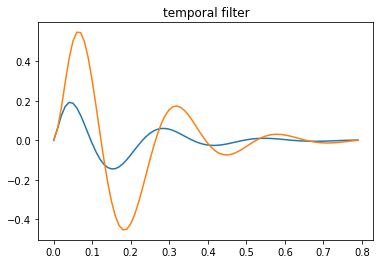

In [8]:
TKtaxis = np.arange(0,0.8,dt)
plt.plot(TKtaxis, TDelta_output_y[:len(TKtaxis),int(xlen/dx/2)])
tempTK = TDelta_output_w[:len(TKtaxis),int(xlen/dx/2)]
plt.plot(TKtaxis, tempTK)
plt.title('temporal filter')

In [9]:
delTK = TDelta_output_w[:len(TKtaxis),int(xlen/dx/2)]

# SK

In [10]:
SDelta_input = np.zeros([nstep, int(xlen/dx)+1])
SDelta_input[:, int(xlen/dx/2)] = 2
SDelta_output_w, zts, SDelta_output_y, _, _, _ = FB_FF_1l_1D(SDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

Text(0.5, 1.0, 'spatial filter')

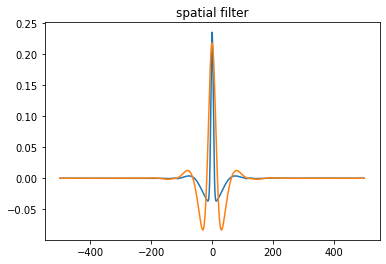

In [11]:
space_window = np.arange(-int(xlen/dx/4),int(xlen/dx/4)+1)
plt.plot(space_window, SDelta_output_y[-1,int(xlen/dx/2)+space_window])
plt.plot(space_window, SDelta_output_w[-1,int(xlen/dx/2)+space_window])
plt.title('spatial filter')

In [12]:
delSK = SDelta_output_w[-1,int(xlen/dx/2)+space_window]

# Spatio-Temporal Kernel

In [13]:
Delta_input = np.zeros([nstep, int(xlen/dx)+1])
Delta_input[0, int(xlen/dx/2)] = 2
Delta_output_w, zts, Delta_output_y, _, _, _ = FB_FF_1l_1D(Delta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

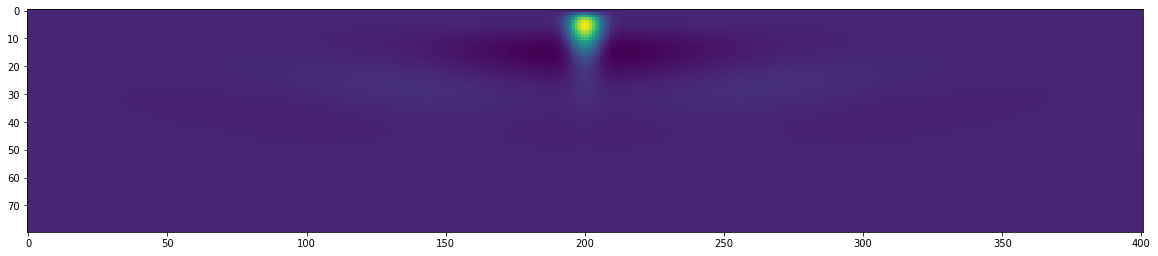

In [14]:
plt.imshow(Delta_output_y[:len(TKtaxis),int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1])
plt.gcf().set_size_inches(20, 5)

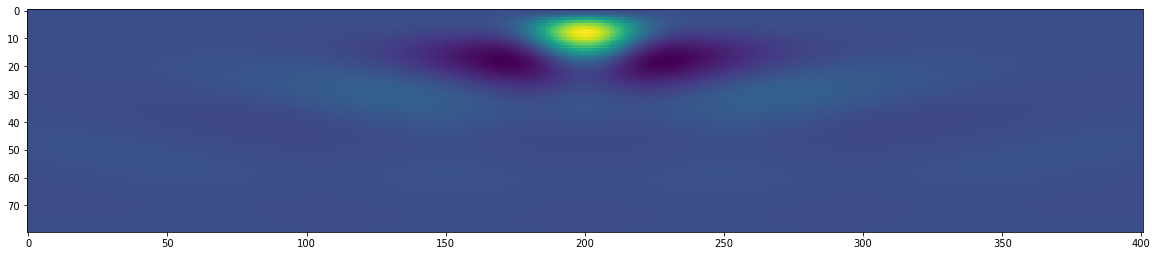

In [15]:
plt.imshow(Delta_output_w[:len(TKtaxis),int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1])
plt.gcf().set_size_inches(20, 5)

In [16]:
delSTK = Delta_output_w[:len(TKtaxis),int(xlen/dx/2)+space_window]

## find extreme

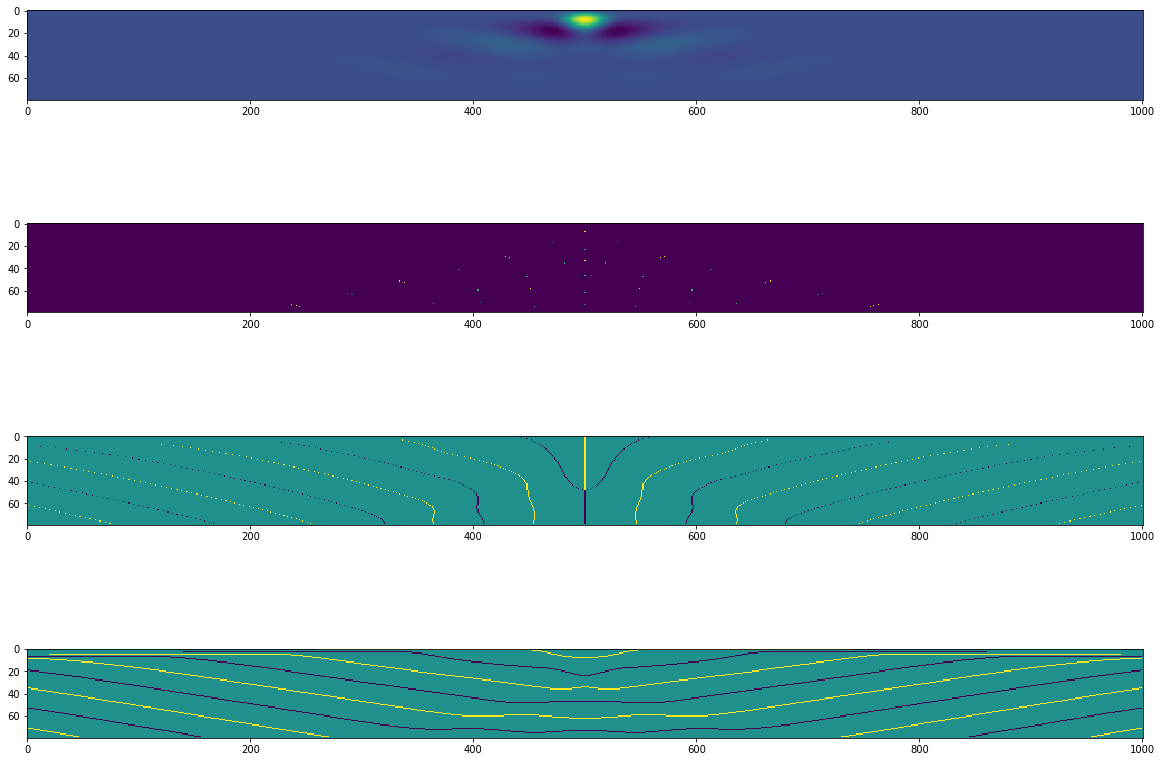

In [17]:
Peak = np.zeros_like(delSTK)
SPeak = np.zeros_like(delSTK)
TPeak = np.zeros_like(delSTK)
for i in np.arange(1,delSTK.shape[0]-1):
    for j in np.arange(1,delSTK.shape[1]-1):
        if delSTK[i,j]>delSTK[i+1,j] and delSTK[i,j]>delSTK[i-1,j]:
            TPeak[i, j] = 1
            if delSTK[i,j]>delSTK[i,j+1] and delSTK[i,j]>delSTK[i,j-1]:
                SPeak[i, j] = 1
                Peak[i, j] = 3
            elif delSTK[i,j]<delSTK[i,j+1] and delSTK[i,j]<delSTK[i,j-1]:
                SPeak[i, j] = -1
                Peak[i, j] = 2
        elif delSTK[i,j]<delSTK[i+1,j] and delSTK[i,j]<delSTK[i-1,j]:
            TPeak[i, j] = -1
            if delSTK[i,j]<delSTK[i,j+1] and delSTK[i,j]<delSTK[i,j-1]:
                SPeak[i, j] = -1
                Peak[i, j] = 1
            elif delSTK[i,j]>delSTK[i,j+1] and delSTK[i,j]>delSTK[i,j-1]:
                SPeak[i, j] = 1
                Peak[i, j] = 2
        else:
            if delSTK[i,j]<delSTK[i,j+1] and delSTK[i,j]<delSTK[i,j-1]:
                SPeak[i, j] = -1
            elif delSTK[i,j]>delSTK[i,j+1] and delSTK[i,j]>delSTK[i,j-1]:
                SPeak[i, j] = 1
fig, ax = plt.subplots(4,1)
ax[0].imshow(delSTK)
ax[1].imshow(Peak)
ax[2].imshow(SPeak)
ax[3].imshow(TPeak)
plt.gcf().set_size_inches(20, 15)

# Separate by Integration

In [18]:
iTk = np.sum(delSTK, axis = 1)*dx
iSk = np.sum(delSTK, axis = 0)*dt

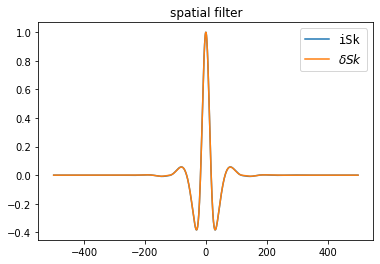

In [19]:
plt.plot(space_window, iSk/max(iSk))
plt.plot(space_window, delSK/max(delSK))
plt.title('spatial filter')

plt.legend( ('iSk', r'$\delta Sk$'), loc='best', prop={'size': 'large', 'family': 'monospace'})

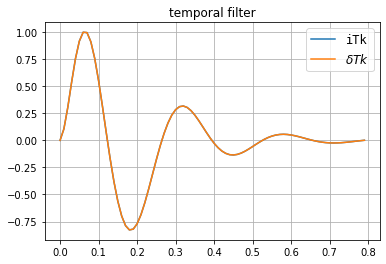

In [20]:
plt.plot(TKtaxis, iTk/max(iTk))
plt.plot(TKtaxis, delTK/max(delTK))
plt.grid()

plt.title('temporal filter')

plt.legend( ('iTk', r'$\delta Tk$'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [21]:
sSTk = iSk[np.newaxis,:]*iTk[:, np.newaxis]
# ssSTk = cut_Delta_output[np.newaxis,:]*np.flipud(n_TK[:len(iTk), np.newaxis])

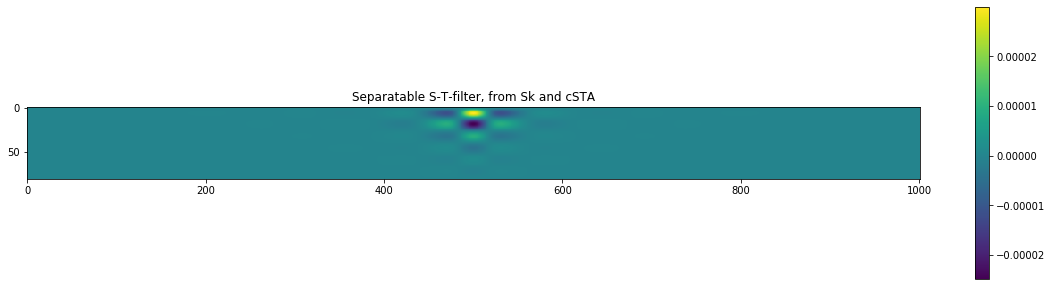

In [22]:
plt.imshow(sSTk)
plt.colorbar()
plt.title('Separatable S-T-filter, '+'from Sk and cSTA')
fig = plt.gcf()
fig.set_size_inches(20, 5)

# Apply SVD on Spatial-Temporal Kernel

In [23]:
from numpy import linalg as la
U,sigma,VT=la.svd(delSTK)

In [24]:
(sigma/sum(sigma))[:5]

array([0.51248467, 0.29480272, 0.11610828, 0.04676442, 0.01886163])

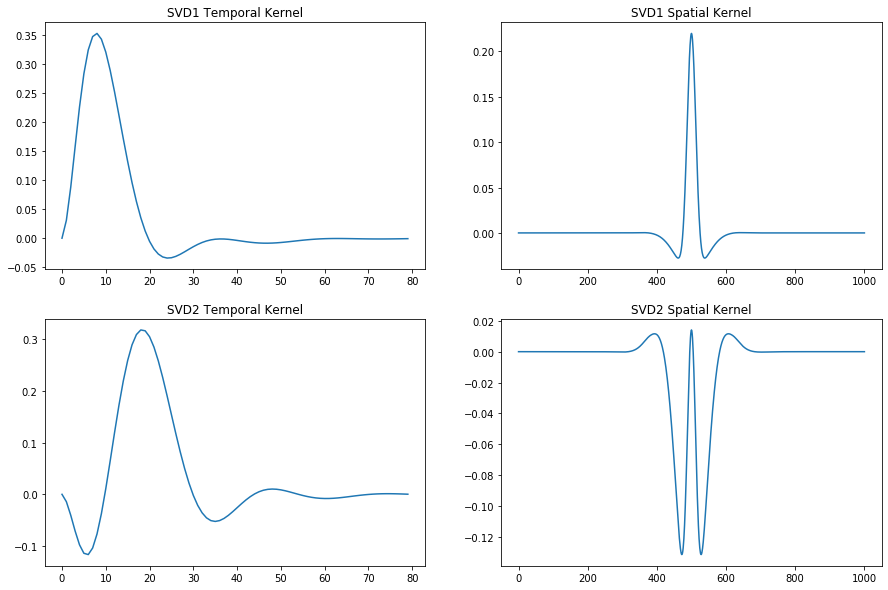

In [25]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

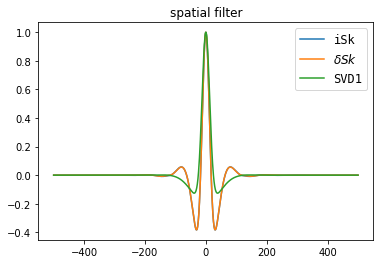

In [26]:
plt.plot(space_window, iSk/max(iSk), label = 'iSk')
plt.plot(space_window, delSK/max(delSK), label = r'$\delta Sk$')
plt.plot(space_window, VT[0,:]/max(VT[0,:]), label = 'SVD1')
# plt.plot(space_window, VT[1,:]/max(VT[1,:]), label = 'SVD2')

plt.title('spatial filter')
plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

# plt.xlim([-30, 30])

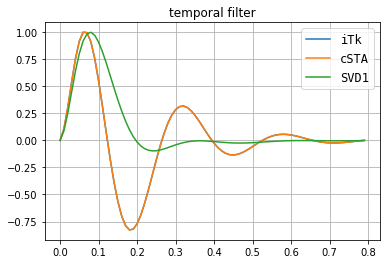

In [27]:
plt.plot(TKtaxis, iTk/max(iTk))
plt.plot(TKtaxis, delTK/max(delTK))
plt.plot(TKtaxis, U[:,0]/max(U[:,0]))
# plt.plot(TKtaxis, U[:,1]/max(U[:,1]))
plt.grid()

plt.title('temporal filter')

plt.legend( ('iTk', 'cSTA', 'SVD1', 'SVD2'), loc='best', prop={'size': 'large', 'family': 'monospace'})

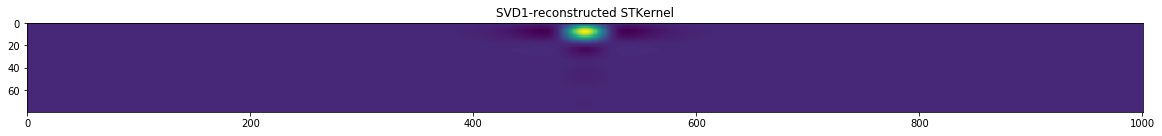

In [28]:
cSVD = 0
SVD_STkernel = np.matmul(U[:,cSVD][:, np.newaxis], VT[cSVD,:][np.newaxis, :])
plt.imshow(SVD_STkernel)
plt.title('SVD'+str(cSVD+1)+'-reconstructed STKernel')
fig = plt.gcf()
fig.set_size_inches(20, 5)

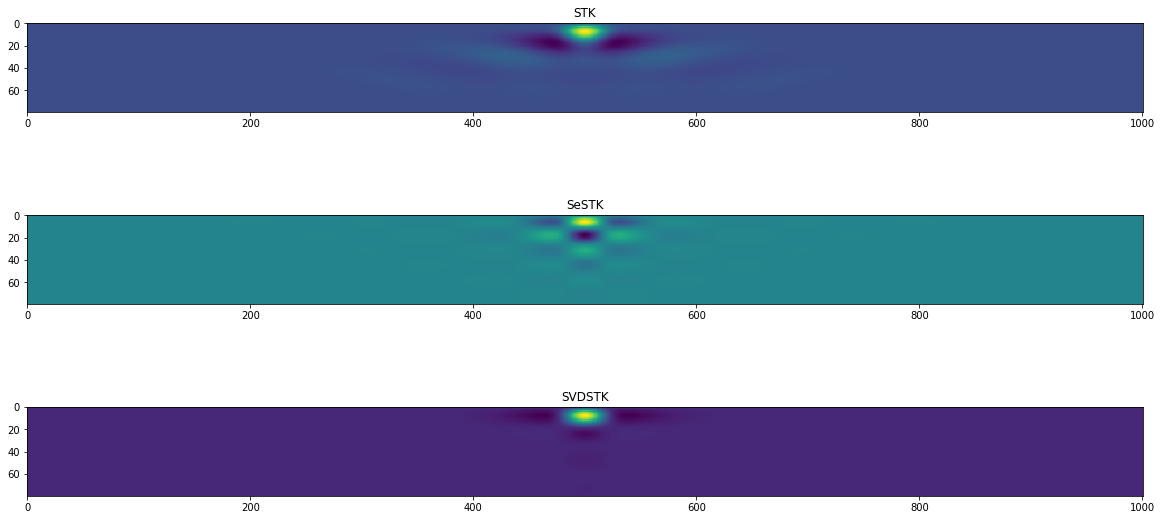

In [29]:
fig, ax = plt.subplots(3,1)
ax[0].imshow(delSTK)
ax[0].set_title('STK')
ax[1].imshow(sSTk)
ax[1].set_title('SeSTK')
ax[2].imshow(SVD_STkernel)
ax[2].set_title('SVDSTK')
plt.gcf().set_size_inches(20, 10)

Rs2d = np.max(delSTK)/np.max(sSTk)

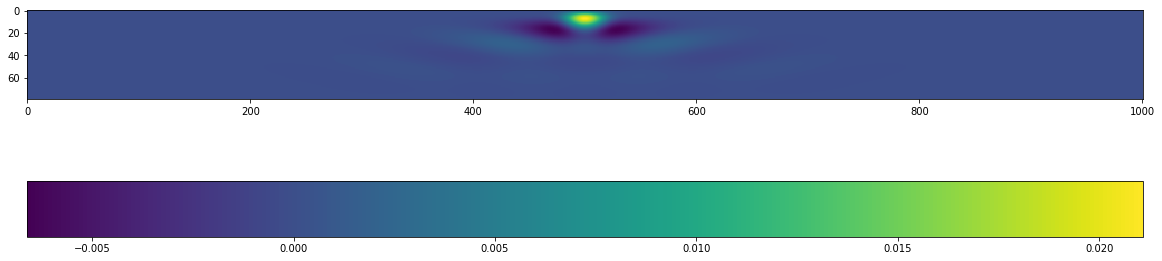

In [30]:
plt.imshow(delSTK)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(20, 10)

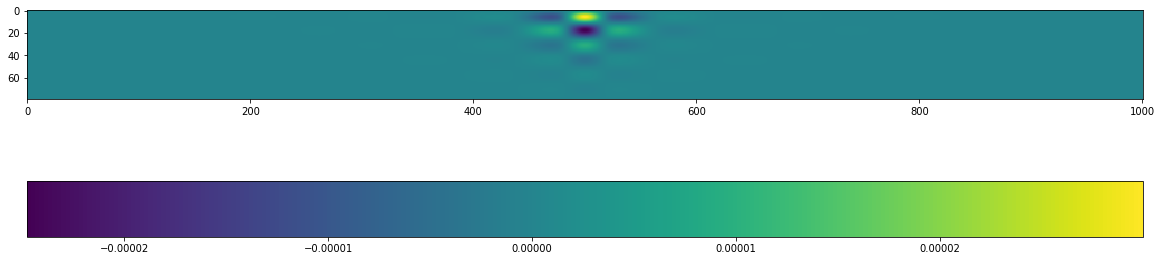

In [31]:
plt.imshow(sSTk)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(20, 10)

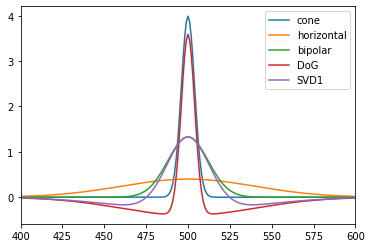

In [32]:
KC = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['C'])
KH = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['H'])
KB = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['B'])
plt.plot(KC, label = 'cone')
plt.plot(KH, label = 'horizontal')
plt.plot(KB, label = 'bipolar')
plt.plot(KC-KH, label = 'DoG')
plt.plot(VT[0,:]/max(VT[0,:])*max(KB), label = 'SVD1')

plt.xlim([500-100, 500+100])
plt.legend()

[ 4.89208358 41.83891453  8.47325183 12.69765563]


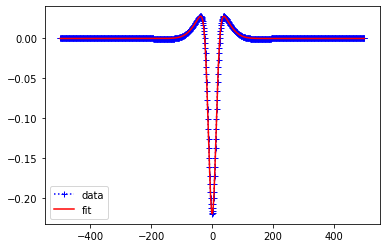

In [33]:
from scipy.optimize import curve_fit
SK = -VT[0,:]

def DoG(x, a1, sigma1, a2, sigma2):
    return a1*Gaussian_filter_1d(x,sigma1)-a2*Gaussian_filter_1d(x,sigma2)

popt,pcov = curve_fit(DoG, space_window, SK, p0=[max(SK), 23, 0.1*max(SK), 5*23], bounds = (0, np.inf))
# popt,pcov = curve_fit(DoG, space_window, SK, p0=[max(SK)/2, 23, -0.1*max(SK), 5*23])
print(popt)

plt.plot(space_window, SK, 'b+:', label='data')
plt.plot(space_window,  DoG(space_window, *popt), 'r-', label='fit')
plt.legend()

In [34]:
FBFF_sigma_dict

{'H': 1, 'C': 0.1, 'tau_y': 0.02, 'B': 0.3}

# Constant Moving Bar

## delta & v=1

In [35]:
moving_bar = np.zeros([nstep, int(xlen/dx)+1])
v = 1 #xstep/tstep
pos = 600
speak = np.zeros(nstep)
for i in range(nstep):
    pos = pos+v
    moving_bar[i, pos] = 1
pos

760

In [36]:
wts, zts, yts, rpeak1 , rpeak2, rinvertpeak2  = FB_FF_1l_1D(moving_bar, FBFF_sigma_dict, FBFF_para_dict, dx, dt)
SbS_output = wts

mb_y = STconvolve(moving_bar,delSTK,dx,dt)
SeSTK_y = STconvolve(moving_bar,sSTk,dx,dt)
SVDSTK_y = STconvolve(moving_bar,SVD_STkernel,dx,dt)

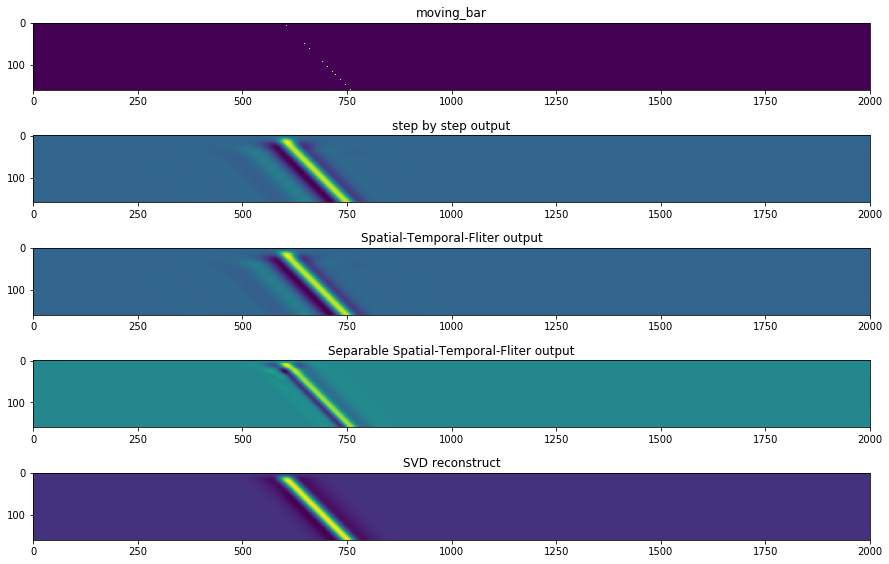

In [37]:
fig, ax = plt.subplots(5,1) 
ax[0].imshow(moving_bar)
ax[0].set_title('moving_bar')
ax[1].imshow(SbS_output)
ax[1].set_title('step by step output')
ax[2].imshow(mb_y)
ax[2].set_title('Spatial-Temporal-Fliter output')
ax[3].imshow(SeSTK_y)
ax[3].set_title('Separable Spatial-Temporal-Fliter output')
ax[4].imshow(SVDSTK_y)
ax[4].set_title('SVD reconstruct')
fig.set_size_inches(15, 10)

## Staty State

In [38]:
def SquareWave(hw):
    xaxis = np.arange(-hw-1, hw+2)
    SW = np.ones_like(xaxis)
    SW[[0,-1]] = 0
    return SW

def GaussianWave(sigma):
    xaxis = np.arange(-5*sigma, 5*sigma+1)
    return (np.exp(-(xaxis/sigma)**2/2))

In [39]:
def StadyState_ConstMoveDelta(v, Kernel):
    last_mb_y = np.zeros_like(Kernel[0,:])
    for k in range(Kernel.shape[0]):
        shift = int(v*k)
        last_mb_y += np.append(Kernel[k,shift:], np.zeros(shift))
    return last_mb_y

In [40]:
delSTKv1 = StadyState_ConstMoveDelta(1, delSTK)
sSTkv1 = StadyState_ConstMoveDelta(1, sSTk)

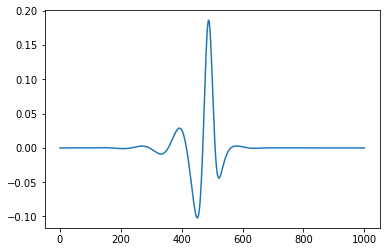

In [41]:
plt.plot(delSTKv1)

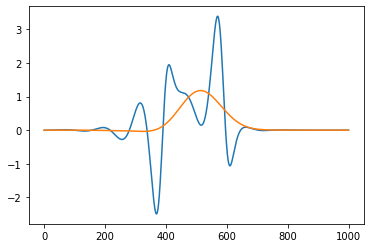

In [42]:
plt.plot(np.convolve(delSTKv1, SquareWave(100), 'same'))
plt.plot(np.convolve(delSTKv1, GaussianWave(100*0.8), 'same'))

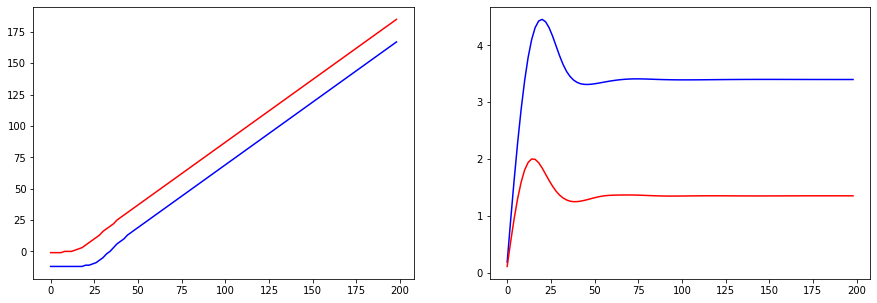

In [43]:
fig, ax = plt.subplots(1,2)
hw_list = np.arange(0,200,2)
del_hw2y = np.array([np.convolve(delSTKv1, SquareWave(hw), 'same') for hw in hw_list])
se_hw2y = np.array([np.convolve(sSTkv1, SquareWave(hw), 'same') for hw in hw_list])

ax[0].plot(hw_list, np.argmax(del_hw2y, axis = 1)-501, c='b')
ax[0].plot(hw_list, np.argmax(se_hw2y, axis = 1)-501, c='r')

ax[1].plot(hw_list, np.max(del_hw2y, axis = 1), c='b')
ax[1].plot(hw_list, np.max(se_hw2y, axis = 1)*Rs2d, c='r')
    
fig.set_size_inches(15,5)

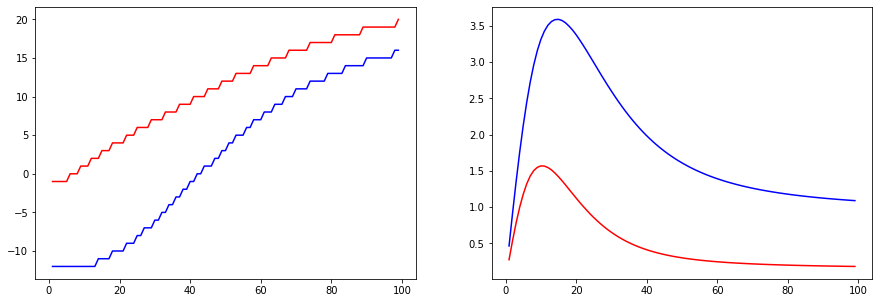

In [44]:
fig, ax = plt.subplots(1,2)
sigma_list = np.arange(1,100,1)
del_sigma2y = np.array([np.convolve(delSTKv1, GaussianWave(sigma), 'same') for sigma in sigma_list])
se_sigma2y = np.array([np.convolve(sSTkv1, GaussianWave(sigma), 'same') for sigma in sigma_list])

ax[0].plot(sigma_list, np.argmax(del_sigma2y, axis = 1)-501, c='b')
ax[0].plot(sigma_list, np.argmax(se_sigma2y, axis = 1)-501, c='r')

ax[1].plot(sigma_list, np.max(del_sigma2y, axis = 1), c='b')
ax[1].plot(sigma_list, np.max(se_sigma2y, axis = 1)*Rs2d, c='r')
    
fig.set_size_inches(15,5)

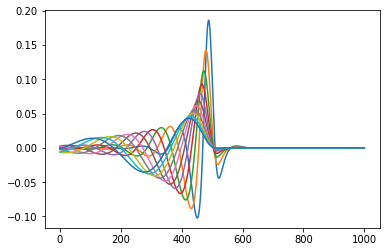

In [45]:
for v in np.arange(1,12,1):
    plt.plot(StadyState_ConstMoveDelta(v, delSTK))

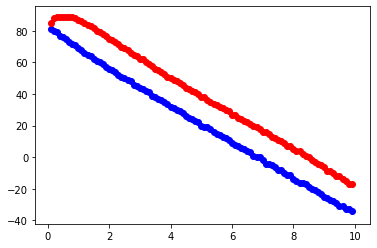

In [46]:
hw = 100
for v in np.arange(0.1,10,0.1):
    plt.scatter(v, np.argmax(np.convolve(StadyState_ConstMoveDelta(v, delSTK), SquareWave(hw), 'same'))-501, c='b')
    plt.scatter(v, np.argmax(np.convolve(StadyState_ConstMoveDelta(v, sSTk), SquareWave(hw), 'same'))-501, c='r')

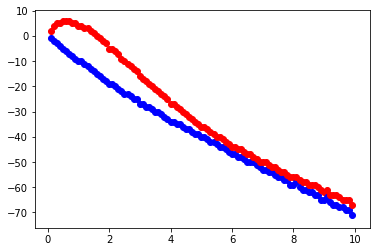

In [47]:
sigma = 20
for v in np.arange(0.1,10,0.1):
    plt.scatter(v, np.argmax(np.convolve(StadyState_ConstMoveDelta(v, delSTK), GaussianWave(sigma), 'same'))-501, c='b')
    plt.scatter(v, np.argmax(np.convolve(StadyState_ConstMoveDelta(v, sSTk), GaussianWave(sigma), 'same'))-501, c='r')

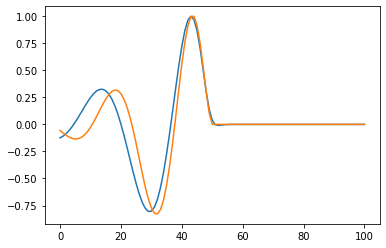

In [48]:
delSTKv = StadyState_ConstMoveDelta(10, delSTK)
plt.plot((delSTKv/max(delSTKv))[::10])

new_TK = np.flip(np.append(np.zeros(50),delTK[:51]))
plt.plot(new_TK/max(new_TK))

In [49]:
# new_TK = np.flip(np.append(np.zeros(50),delTK[:51]))
# nnTK = signal.resample(new_TK, len(new_TK)*5)[:-4]
# testSKcTK = np.convolve(delSK, nnTK, 'same')
# plt.plot(testSKcTK/ max(testSKcTK))

# LPOU

## please check parameters here

In [50]:
## sigma_bipolar = 0.3 <-> RFradius = (1.5*sigma) = 300 micro
## Dynamical range: 1.4 mm = 7*RFsigma
##                  7*sigma_bipolar = 21 = 21/dx xstep 
DR = 7*FBFF_sigma_dict['B']/dx
DR/2

42.0

In [51]:
Tto = 60
LPOU = SSG([1], dt, Tto, tau = 1, D = 1)[0]
rsLPOU = (LPOU-min(LPOU))/(max(LPOU)-min(LPOU))*DR

In [52]:
LPOU_bar = np.zeros([len(LPOU),int(DR)*3])
for i in range(len(LPOU)):
    LPOU_bar[i, int(DR+rsLPOU[i])] = 1

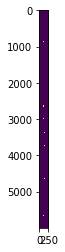

In [53]:
plt.imshow(LPOU_bar)

In [54]:
# @jit
def STconvolve(x,k,dx,dt):
    output = np.zeros([x.shape[0],k.shape[1]])
    for i in range(x.shape[0]):
        for ii in np.arange(max(i-k.shape[0]+1, 0), i+1):
            output[i,:] += np.convolve(x[ii,:],k[i-ii, :],'same')*dx*dt
    return output

mb_y = STconvolve(LPOU_bar,delSTK,dx,dt)
SeSTK_y = STconvolve(LPOU_bar,sSTk,dx,dt)
SVDSTK_y = STconvolve(LPOU_bar,SVD_STkernel,dx,dt)

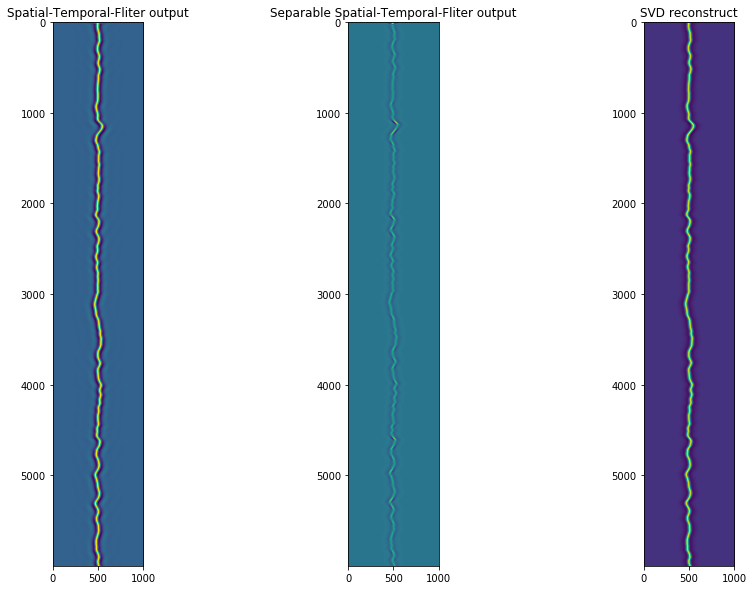

In [55]:
fig, ax = plt.subplots(1,3) 
ax[0].imshow(mb_y)
ax[0].set_title('Spatial-Temporal-Fliter output')
ax[1].imshow(SeSTK_y)
ax[1].set_title('Separable Spatial-Temporal-Fliter output')
ax[2].imshow(SVDSTK_y)
ax[2].set_title('SVD reconstruct')
fig.set_size_inches(15, 10)

## MI

### WF

In [94]:
zerodelTK = np.append(np.zeros(len(delTK)-1), delTK)
WFy = np.convolve(rsLPOU, zerodelTK, 'same')

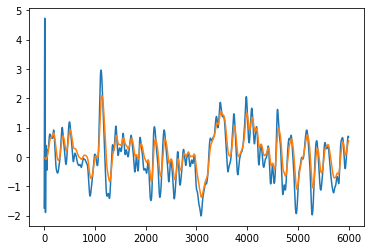

In [96]:
plt.plot((WFy-np.mean(WFy))/20)
plt.plot(LPOU)
r1 = WFy

In [97]:
r = NL(-r1+np.mean(r1), 0)
ratio = sum(r)/Tto/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
ystate, _ = np.histogram(FakeSpike, np.arange(0,Tto+dt,dt))

In [98]:
state_num = 6
xstate = EqualState(LPOU, state_num)[0]
v = np.append(0, np.diff(LPOU))/dt
vstate = EqualState(v, state_num)[0]

In [99]:
window = [-1,1] # second
timeshift, Information = PIfunc(ystate, xstate, vstate, dt, window)

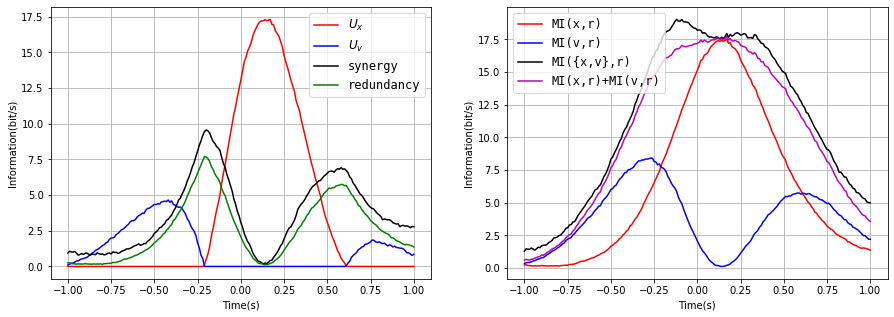

In [100]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

#plot MIs
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)

### STK 

(5, -5)

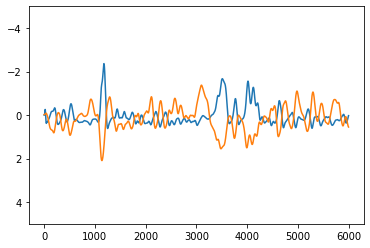

In [136]:
CellIndex = 568 # center
r1 = mb_y[:, CellIndex]
# plt.plot((WFy-np.mean(WFy))/3)
plt.plot(mb_y[:, CellIndex]*1E5)
plt.plot(LPOU)
plt.ylim([5,-5])

In [137]:
r = NL(r1-np.mean(r1), 0)
ratio = sum(r)/Tto/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
ystate, _ = np.histogram(FakeSpike, np.arange(0,Tto+dt,dt))

In [138]:
state_num = 6
xstate = EqualState(LPOU, state_num)[0]
v = np.append(0, np.diff(LPOU))/dt
vstate = EqualState(v, state_num)[0]

In [139]:
window = [-1,1] # second
timeshift, Information = PIfunc(ystate, xstate, vstate, dt, window)

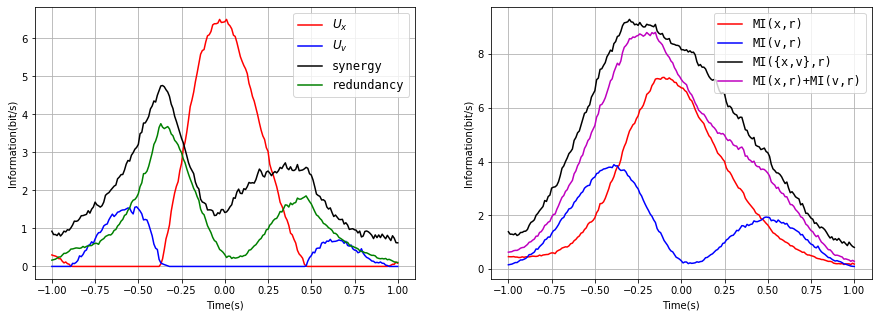

In [140]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

#plot MIs
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)

### SeSTK 

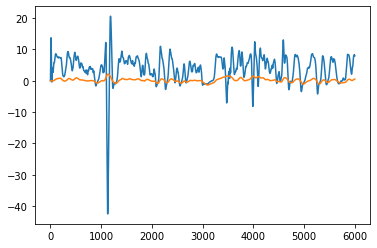

In [67]:
# CellIndex = 591 # center
r1 = SeSTK_y[:, CellIndex]
plt.plot(SeSTK_y[:, CellIndex]*1E10)
plt.plot(LPOU)

In [68]:
r = NL(r1-np.mean(r1), 0)
ratio = sum(r)/Tto/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
ystate, _ = np.histogram(FakeSpike, np.arange(0,Tto+dt,dt))

In [69]:
window = [-1,1] # second
timeshift, Information = PIfunc(ystate, xstate, vstate, dt, window)

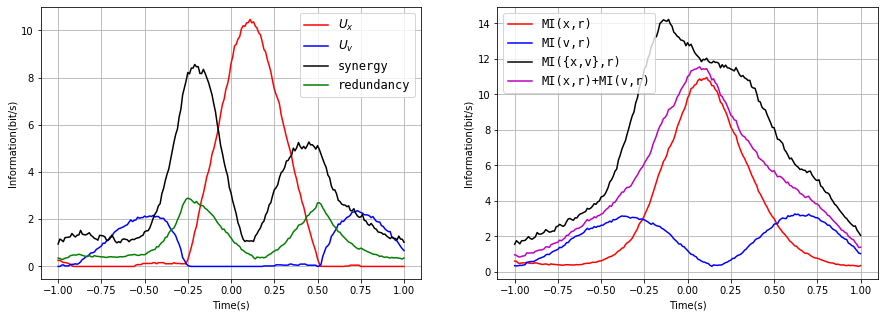

In [70]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

#plot MIs
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)

## hw

In [148]:
# hw = 10
hwSTKy = np.zeros_like(mb_y)
hwSeSTKy = np.zeros_like(SeSTK_y)
for i in range(mb_y.shape[0]):
    hwSTKy[i,:] = np.convolve(mb_y[i,:], SquareWave(hw), 'same')
    hwSeSTKy[i,:] = np.convolve(SeSTK_y[i,:], SquareWave(hw), 'same')

In [149]:
##verify that convolution with wave form can be before or after Kernel

# LPOU_bar_hw = np.zeros_like(LPOU_bar)
# for i in range(LPOU_bar.shape[0]):
#     LPOU_bar_hw[i,:] = np.convolve(LPOU_bar[i,:], SquareWave(hw), 'same')
# hwSTKy_CB = STconvolve(LPOU_bar_hw,delSTK,dx,dt)

# I = 3000
# plt.plot(hwSTKy[I,:])
# plt.plot(hwSTKy_CB[I,:])

# np.sum(hwSTKy-hwSTKy_CB)/np.sum(hwSTKy+hwSTKy_CB)

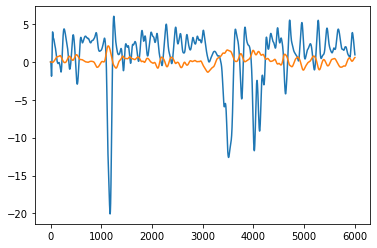

In [150]:
CellIndex = 573 # center
r1 = hwSTKy[:, CellIndex]
plt.plot(hwSTKy[:, CellIndex]*1E6/(2*hw+1))
plt.plot(LPOU)

In [151]:
r = NL(r1-np.mean(r1), 0)
ratio = sum(r)/Tto/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
ystate, _ = np.histogram(FakeSpike, np.arange(0,Tto+dt,dt))

In [152]:
window = [-1,1] # second
timeshift, Information = PIfunc(ystate, xstate, vstate, dt, window)

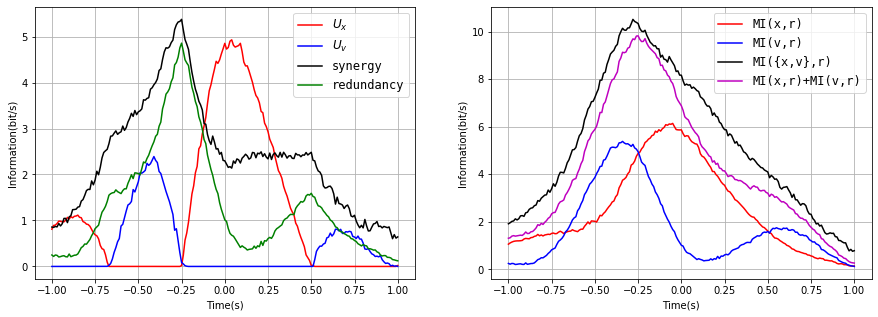

In [153]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

#plot MIs
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)

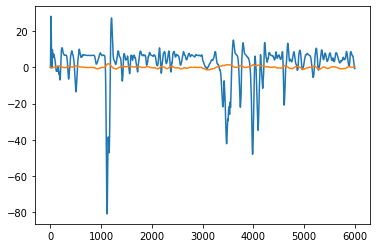

In [77]:
# CellIndex = 591 # center
r1 = hwSeSTKy[:, CellIndex]
plt.plot(hwSeSTKy[:, CellIndex]*1E10/(2*hw+1))
plt.plot(LPOU)

In [78]:
r = NL(r1-np.mean(r1), 0)
ratio = sum(r)/Tto/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
ystate, _ = np.histogram(FakeSpike, np.arange(0,Tto+dt,dt))

In [79]:
window = [-1,1] # second
timeshift, Information = PIfunc(ystate, xstate, vstate, dt, window)

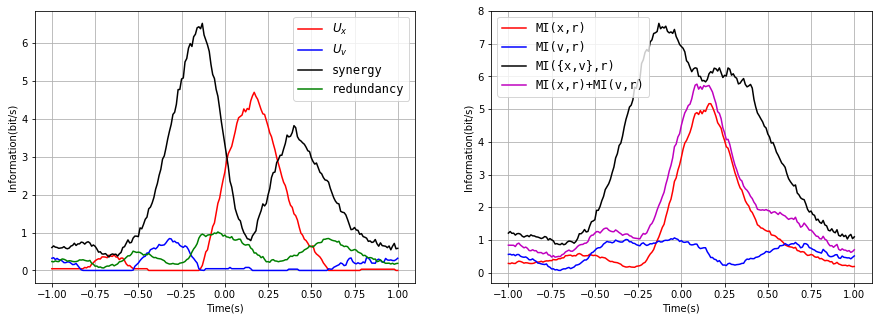

In [80]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

#plot MIs
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)

## $\sigma$

In [141]:
sigma = (2*hw+1)/(np.sqrt(2*np.pi))
sigSTKy = np.zeros_like(mb_y)
sigSeSTKy = np.zeros_like(SeSTK_y)
for i in range(mb_y.shape[0]):
    sigSTKy[i,:] = np.convolve(mb_y[i,:], GaussianWave(sigma), 'same')
    sigSeSTKy[i,:] = np.convolve(SeSTK_y[i,:], GaussianWave(sigma), 'same')

In [142]:
##verify that convolution with wave form can be before or after Kernel

# LPOU_bar_hw = np.zeros_like(LPOU_bar)
# for i in range(LPOU_bar.shape[0]):
#     LPOU_bar_hw[i,:] = np.convolve(LPOU_bar[i,:], SquareWave(hw), 'same')
# hwSTKy_CB = STconvolve(LPOU_bar_hw,delSTK,dx,dt)

# I = 3000
# plt.plot(hwSTKy[I,:])
# plt.plot(hwSTKy_CB[I,:])

# np.sum(hwSTKy-hwSTKy_CB)/np.sum(hwSTKy+hwSTKy_CB)

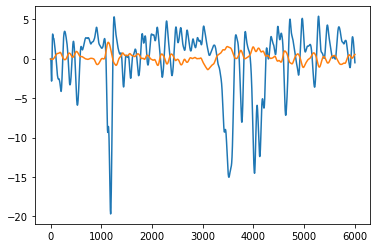

In [143]:
# CellIndex = 573 # center
r1 = sigSTKy[:, CellIndex]
plt.plot(sigSTKy[:, CellIndex]*1E6/(2*hw+1))
plt.plot(LPOU)

In [144]:
r = NL(r1-np.mean(r1), 0)
ratio = sum(r)/Tto/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
ystate, _ = np.histogram(FakeSpike, np.arange(0,Tto+dt,dt))

In [145]:
window = [-1,1] # second
timeshift, Information = PIfunc(ystate, xstate, vstate, dt, window)

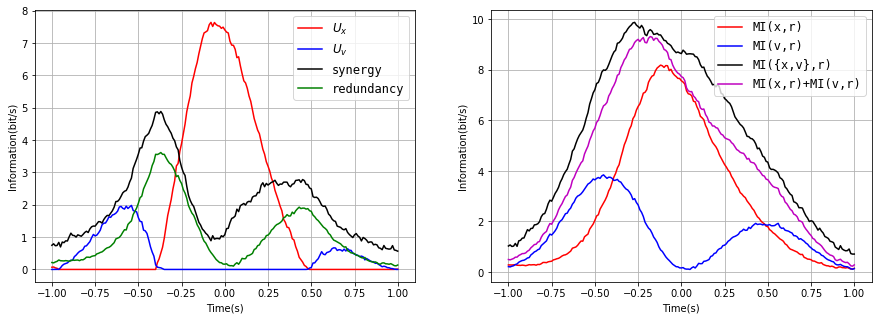

In [146]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

#plot MIs
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)

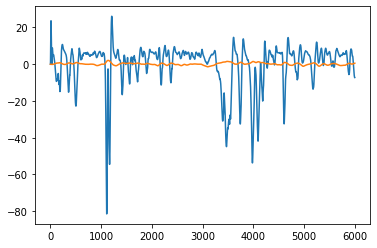

In [147]:
# CellIndex = 591 # center
r1 = sigSeSTKy[:, CellIndex]
plt.plot(sigSeSTKy[:, CellIndex]*1E10/(2*hw+1))
plt.plot(LPOU)

In [88]:
r = NL(r1-np.mean(r1), 0)
ratio = sum(r)/Tto/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
ystate, _ = np.histogram(FakeSpike, np.arange(0,Tto+dt,dt))

In [89]:
window = [-1,1] # second
timeshift, Information = PIfunc(ystate, xstate, vstate, dt, window)

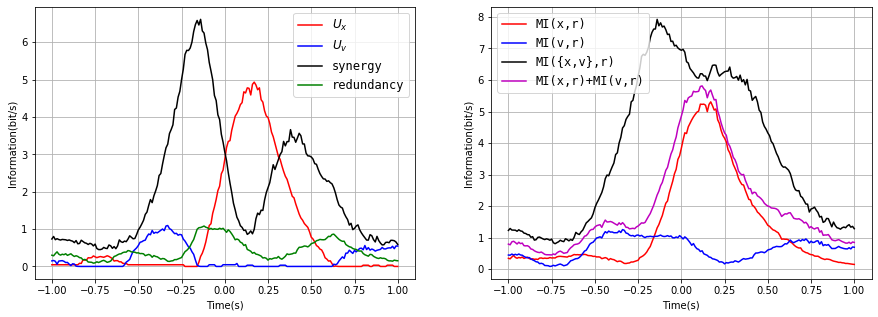

In [90]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

#plot MIs
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5)